In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

df = pd.read_csv('/content/drive/MyDrive/Gold Project/Models/LSTM Future Predict/Gold Price (2013-2023).csv')

In [2]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


In [4]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [7]:
df

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.00,1672.10
1,2013-01-03,1675.6,1688.0,1689.30,1664.30
2,2013-01-04,1649.9,1664.4,1664.40,1630.00
3,2013-01-07,1647.2,1657.3,1663.80,1645.30
4,2013-01-08,1663.2,1651.5,1662.60,1648.80
...,...,...,...,...,...
2578,2022-12-26,1809.7,1805.8,1811.95,1805.55
2579,2022-12-27,1823.1,1808.2,1841.90,1808.00
2580,2022-12-28,1815.8,1822.4,1822.80,1804.20
2581,2022-12-29,1826.0,1812.3,1827.30,1811.20


In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum().sum()

0

In [10]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [11]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

260

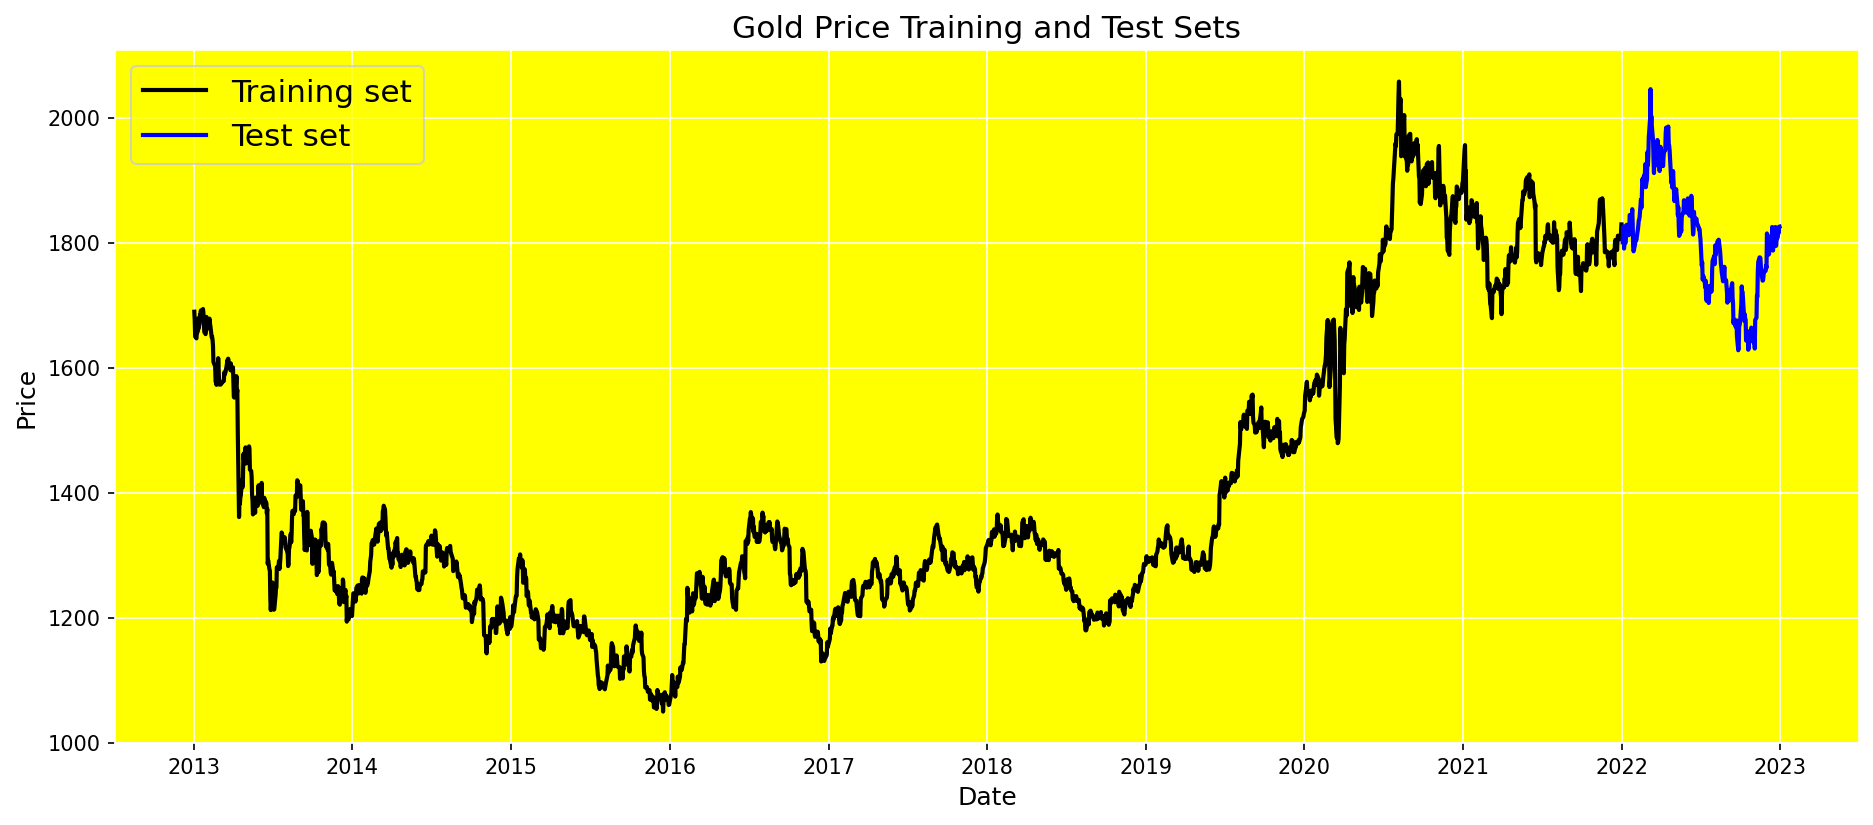

In [12]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [13]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [14]:
window_size = 60

In [15]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [16]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [17]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [18]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [19]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [20]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [21]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2263, 60, 1)
y_train Shape:  (2263, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)


In [22]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [23]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - loss: 0.0731 - val_loss: 0.1265
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0203 - val_loss: 0.0459
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0090 - val_loss: 0.0207
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0061 - val_loss: 0.0081
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 8/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 9/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0019 - val_loss: 0.0058
Epoch 10/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 0.0015 - val_loss: 0.0072
Epoch 11/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0014 - val_loss: 0.0088
Epoch 12/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 

In [24]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.2277e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


In [25]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [26]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0008420433732680976
Test MAPE: 0.031047423260260814
Test Accuracy: 0.9689525767397392


In [27]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

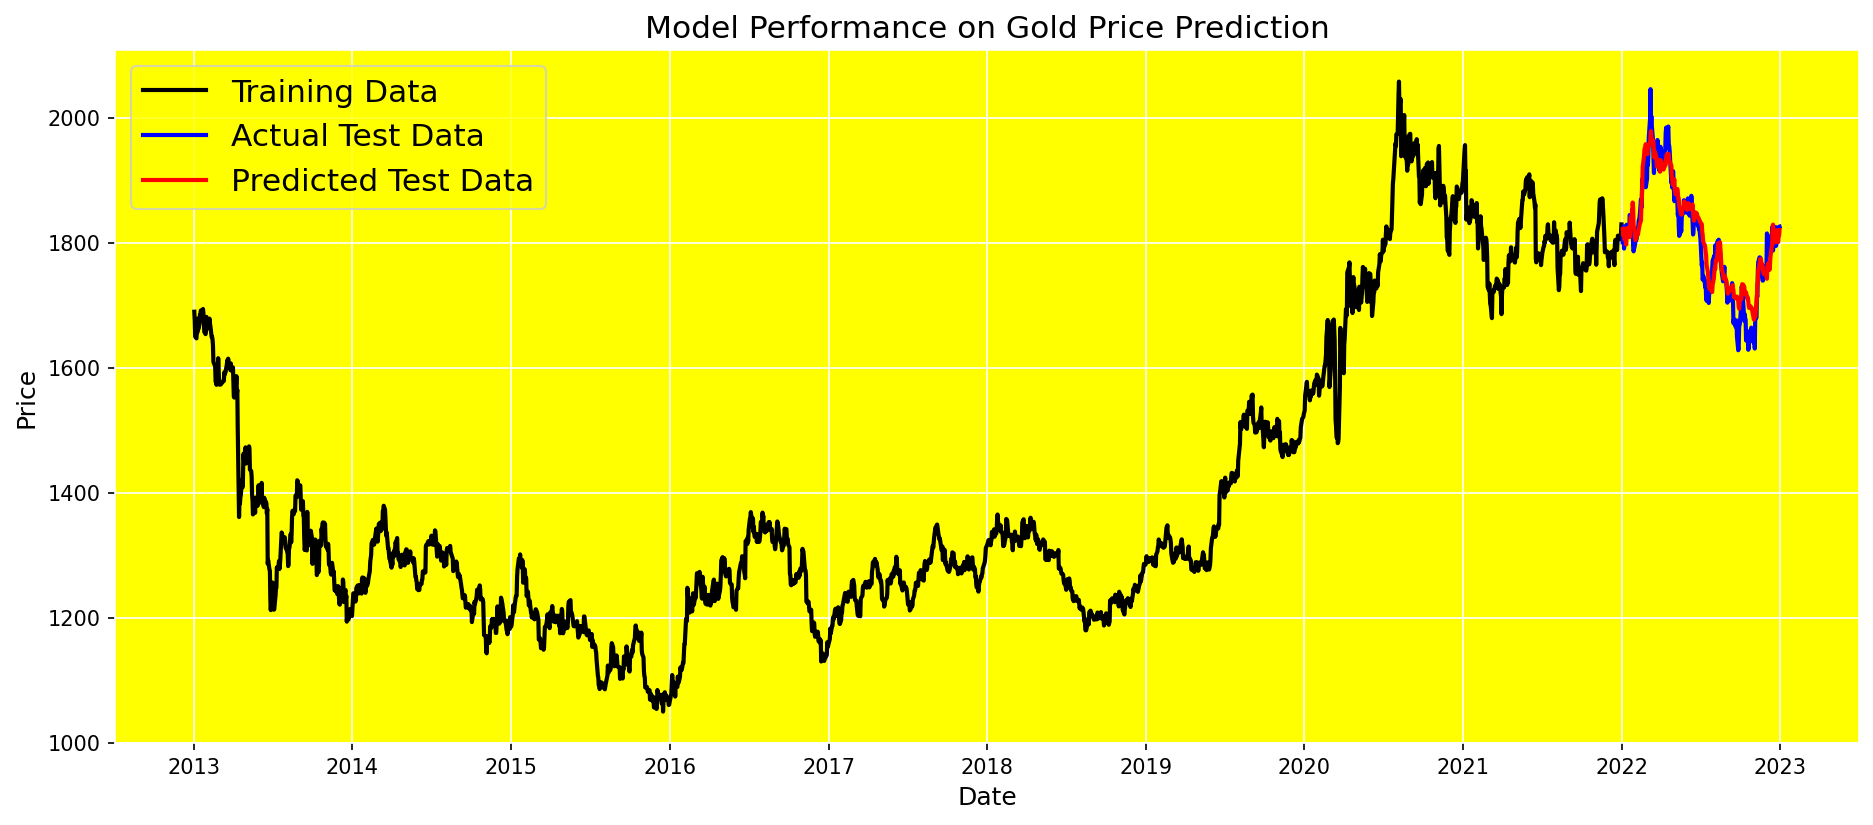

In [28]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [29]:
model.save("lstm_gld_price_model.h5")

In [38]:
from tensorflow.keras.models import load_model

model = load_model("/content/lstm_gld_price_model.h5")

# Load scaler (Ensure it was saved earlier with the same scaling parameters)
scaler = MinMaxScaler()
# df = pd.read_csv("gold_prices.csv")  # Replace with actual dataset file
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))  # Refit using training data

window_size = 60

In [39]:
def predict_future_prices(last_prices, future_days=10):
    """
    Predict future gold prices using the pre-trained LSTM model.

    :param last_prices: A list or NumPy array of the last `window_size` prices.
    :param future_days: Number of future days to predict.
    :return: A list of predicted future prices (in the original scale).
    """
    last_prices = np.array(last_prices).reshape(-1, 1)
    last_prices = scaler.transform(last_prices)  # Normalize input data

    future_predictions = []
    input_sequence = list(last_prices[-window_size:])  # Use last `window_size` prices

    for _ in range(future_days):
        input_data = np.array(input_sequence).reshape(1, window_size, 1)  # Reshape for LSTM
        predicted_price = model.predict(input_data)[0, 0]  # Predict next value
        future_predictions.append(predicted_price)

        # Update input sequence for next iteration
        input_sequence.append([predicted_price])
        input_sequence.pop(0)  # Maintain sequence length

    # Inverse transform predictions to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions.flatten()

In [40]:
last_60_prices = df['Price'].values[-window_size:]  # Get last 60 prices
predicted_prices = predict_future_prices(last_60_prices, future_days=10)

print("Predicted Future Gold Prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Future Gold Prices: [0.7677139  0.7697948  0.77142787 0.7742264  0.7787087  0.7856488
 0.7955618  0.8089194  0.82585    0.8457643 ]


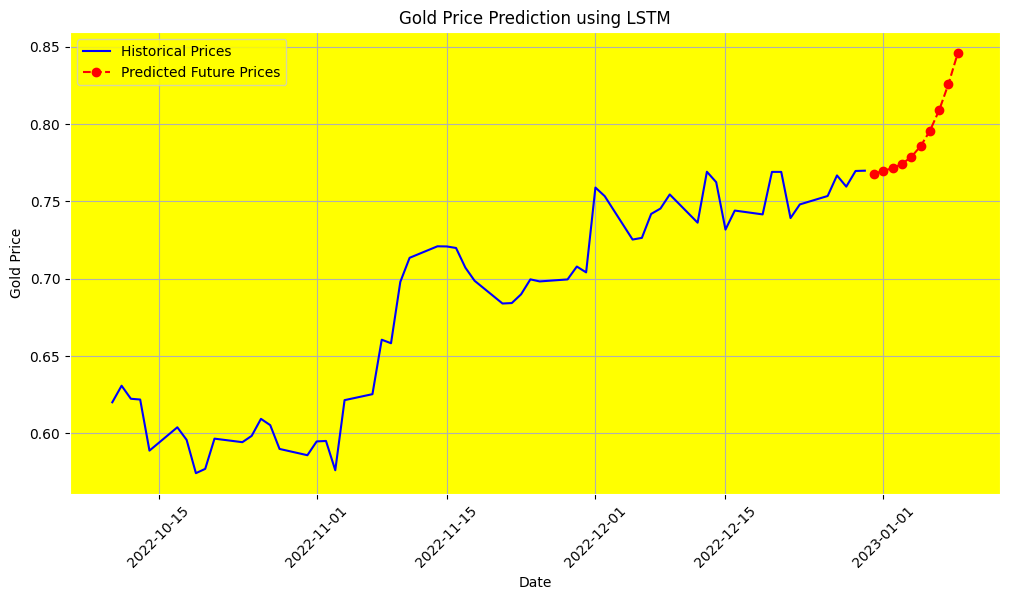

In [41]:
historical_dates = df['Date'].values[-window_size:]  # Get last 60 dates
future_dates = pd.date_range(df['Date'].values[-1], periods=11, freq='D')[1:]  # Generate future dates

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, scaler.inverse_transform(last_60_prices.reshape(-1, 1)), label="Historical Prices", color="blue")
plt.plot(future_dates, predicted_prices, label="Predicted Future Prices", color="red", linestyle="dashed", marker="o")

plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.title("Gold Price Prediction using LSTM")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()